In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import os
import urllib
import csv

import utilities

In [11]:
data_url = 'https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv'
data_dir = os.path.join('data', 'sunspots', 'sunspots.csv')

if ~os.path.exists(data_dir):
    urllib.request.urlretrieve(data_url, data_dir)

In [64]:
with open(data_dir, 'rt') as file:
    reader = csv.reader(file, delimiter=',')
    next(reader)
    
    time, series = [], []
    for row in reader:
        time.append(int(row[0]))
        series.append(float(row[2]))
    time = np.array(time)
    series = np.array(series)
        
print(len(series))
print(time[:10])
print(series[:10])

3235
[0 1 2 3 4 5 6 7 8 9]
[ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8]


In [13]:
def plot_series(series, time=None, line='-', start=0, end=None, label=None,
                vlinex=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if time is None:
        time = range(len(series))
    ax.plot(time[start:end], series[start:end], line, label=label)
    if vlinex is not None:
        ax.axvline(vlinex, c='r')
    utilities.set_ax(ax, xlabel='Time', legend=label is not None, grid=True)

In [65]:
train_size = 2000

train_s, val_s = series[:train_size], series[train_size:]
train_t, val_t = time[:train_size], time[train_size:]

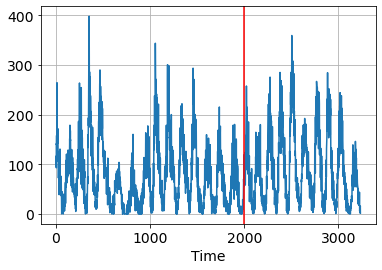

In [66]:
plot_series(series, time, vlinex=time[train_size])

In [67]:
np.abs(val_s[:-1] - val_s[1:]).mean()

19.609076175040517

In [19]:
def series2data(series, window, batch, buffer=None):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda ds: ds.batch(window + 1))
    data = data.map(lambda ts: (ts[:-1], ts[-1]))
    data = data.shuffle(buffer_size=len(series) if buffer is None else buffer)
    data = data.batch(batch).prefetch(1)
    return data

In [68]:
window = 30
batch = 64
chpt = os.path.join('tmp', 'val-mae-chpt')

train_data = series2data(train_s, window, batch)
val_data = series2data(val_s, window, batch)
for x, y in train_data.take(1):
    print(x.shape, y.shape)

(64, 30) (64,)


In [88]:
def fit_nn(model, epochs=20, lr=8e-6, mom=0.9, patience=30, vb=0, chpt=chpt):
    callbacks = []
    callbacks.append(keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True
    ))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=chpt,
        monitor='val_mae',
        save_weights_only=True,
        save_best_only=True
    ))
    
    lr_search = isinstance(lr, (float, int)) and (lr <= 0)
    if lr_search:
        ep2lr = lambda ep: 1e-8 * 10**(ep/20)
        callbacks.append(keras.callbacks.LearningRateScheduler(ep2lr))
    
    model.compile(
        loss=keras.losses.Huber(),
        optimizer=keras.optimizers.SGD(learning_rate=lr if not lr_search else ep2lr(0),
                                       momentum=mom),
        metrics=['mae'],
    )
    
    history = model.fit(
        train_data, epochs=epochs, validation_data=val_data,
        callbacks=callbacks, verbose=vb
    )
    
    if not lr_search:
        utilities.plot_train_val_metrics(history, ['loss', 'mae'], start=10)
    else:
        fig, axs = plt.subplots(1, 2, figsize=[14, 4])
        lrs = ep2lr(np.array(history.epoch))
        for ax in axs:
            ax.semilogx(lrs, history.history['loss'], label='train')
            ax.semilogx(lrs, history.history['val_loss'], label='val')
            utilities.set_ax(ax, 'Learning rate', title='loss', legend=True, grid=True)
        min_loss = min(history.history['loss'])
        axs[1].set_ylim([min_loss, 3*min_loss])
        axs[1].set_xlim([lrs[len(lrs)//2], lrs[-1]])
    
    return model

In [24]:
def plot_pred(model, name='model', combined=False):
    full_data = series2data(series, window=window, batch=128, buffer=1)
    data_x = full_data.map(lambda x, y: x)
    pred = model.predict(data_x).squeeze()
    
    if combined:
        fig, ax = plt.subplots()
        ax.axvline(time[train_size], c='r')
        plot_series(np.c_[series[window:], pred], time[window:], ax=ax,
                    label=['truth', name])

    t_trn, t_val = time[window:train_size], time[train_size:]
    s_trn, s_val = series[window:train_size], series[train_size:]
    pred_trn, pred_val = pred[:train_size-window], pred[train_size-window:]

    rmse_trn = np.sqrt(keras.metrics.mean_squared_error(s_trn, pred_trn))
    mae_trn = keras.metrics.mean_absolute_error(s_trn, pred_trn)

    rmse_val = np.sqrt(keras.metrics.mean_squared_error(s_val, pred_val))
    mae_val = keras.metrics.mean_absolute_error(s_val, pred_val)

    fig, axs = plt.subplots(1, 2, figsize=[14, 4])
    plot_series(np.c_[s_trn, pred_trn], t_trn, ax=axs[0],
                label=('truth', f'{name} rmse={rmse_trn:.3g}, mae={mae_trn:.3g}'))
    plot_series(np.c_[s_val, pred_val], t_val, ax=axs[1],
                label=('truth', f'{name} rmse={rmse_val:.3g}, mae={mae_val:.3g}'))

In [94]:
def build_fcn(fcn_d=[10, 10]):
    ly = keras.layers
    if fcn_d == []:
        layers = [ly.Dense(1, input_shape=[window])]
    else:
        layers = [ly.Dense(fcn_d[0], activation='relu', input_shape=[window])]
        layers += [ly.Dense(d, activation='relu') for d in fcn_d[1:]]
        layers += [ly.Dropout(0.4), ly.Dense(1)]
        
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 44 s
Wall time: 25.5 s


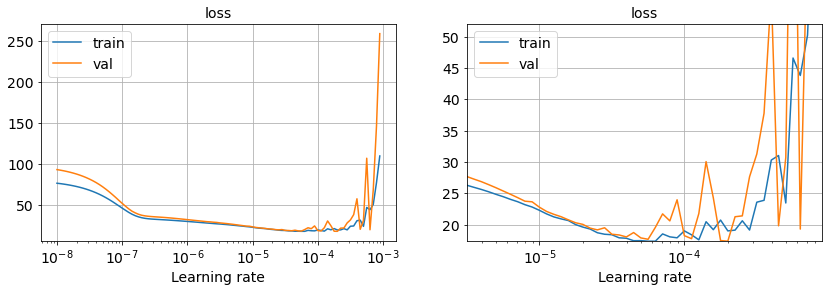

In [53]:
%%time
model = fit_nn(build_fcn(fcn_d=[]), epochs=100, lr=-1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 0s 6ms/step
CPU times: total: 26.8 s
Wall time: 15.9 s


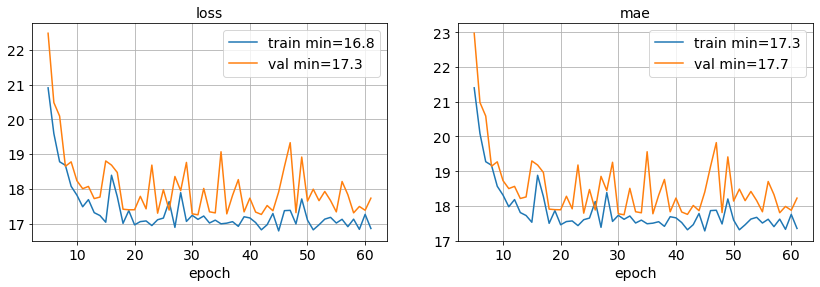

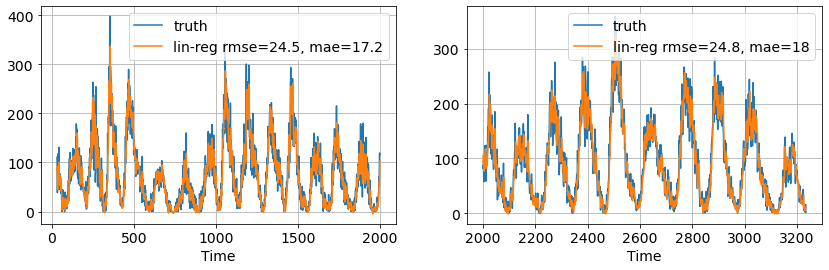

In [54]:
%%time
model = fit_nn(build_fcn(fcn_d=[]), epochs=500, lr=4e-5)
model.load_weights(chpt)
plot_pred(model, name='lin-reg')

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 30)                930       
                                                                 
 dense_68 (Dense)            (None, 30)                930       
                                                                 
 dropout_11 (Dropout)        (None, 30)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 48.3 s
Wall time: 31.2 s


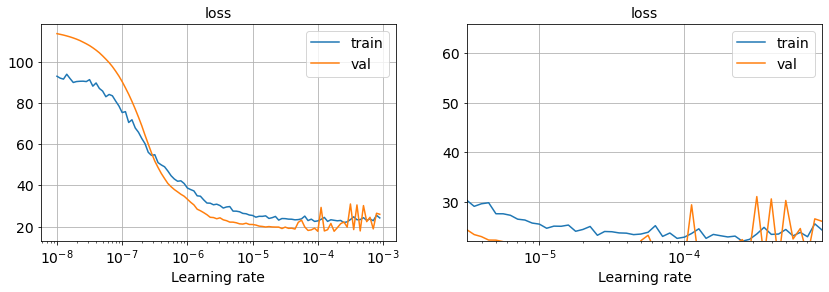

In [96]:
%%time
model = fit_nn(build_fcn([30, 30]), epochs=100, lr=-1)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 30)                930       
                                                                 
 dense_74 (Dense)            (None, 30)                930       
                                                                 
 dropout_13 (Dropout)        (None, 30)                0         
                                                                 
 dense_75 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________
26/26 [==============================] - 0s 6ms/step
CPU times: total: 1min 56s
Wall time: 1min 10s


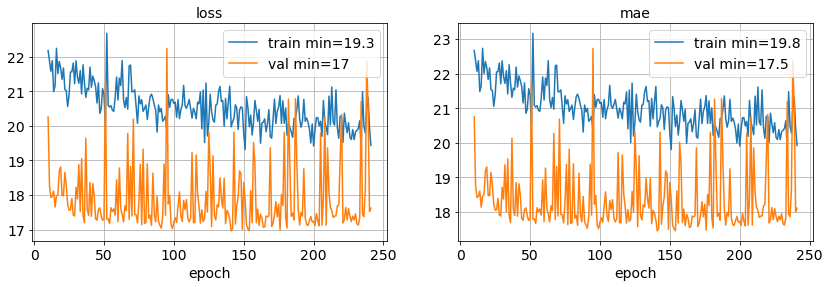

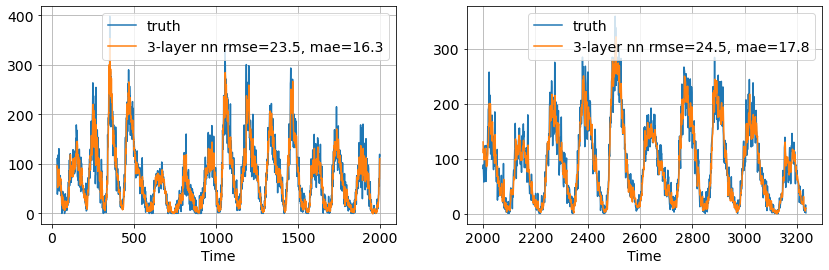

In [98]:
%%time
model = fit_nn(build_fcn([30, 30]), epochs=500, lr=1e-4, patience=100)
model.load_weights(chpt)
plot_pred(model, name='3-layer nn')

In [106]:
def build_cnn(convfil=32, convwid=5):
    ly = keras.layers
    layers = [
        ly.Conv1D(convfil, convwid, activation='relu', input_shape=[window, 1]),
        ly.Flatten(),
        ly.Dense(30, activation='relu'),
        ly.Dense(30, activation='relu'),
        ly.Dropout(0.4),
        ly.Dense(1),
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 26, 32)            192       
                                                                 
 flatten_9 (Flatten)         (None, 832)               0         
                                                                 
 dense_80 (Dense)            (None, 30)                24990     
                                                                 
 dense_81 (Dense)            (None, 30)                930       
                                                                 
 dropout_18 (Dropout)        (None, 30)                0         
                                                                 
 dense_82 (Dense)            (None, 1)                 31        
                                                                 
Total params: 26,143
Trainable params: 26,143
Non-tra

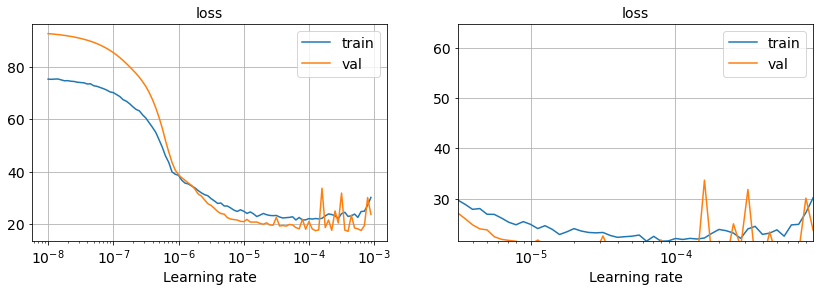

In [107]:
%%time
model = fit_nn(build_cnn(), epochs=100, lr=-1)

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 26, 32)            192       
                                                                 
 flatten_10 (Flatten)        (None, 832)               0         
                                                                 
 dense_83 (Dense)            (None, 30)                24990     
                                                                 
 dense_84 (Dense)            (None, 30)                930       
                                                                 
 dropout_19 (Dropout)        (None, 30)                0         
                                                                 
 dense_85 (Dense)            (None, 1)                 31        
                                                                 
Total params: 26,143
Trainable params: 26,143
Non-tra

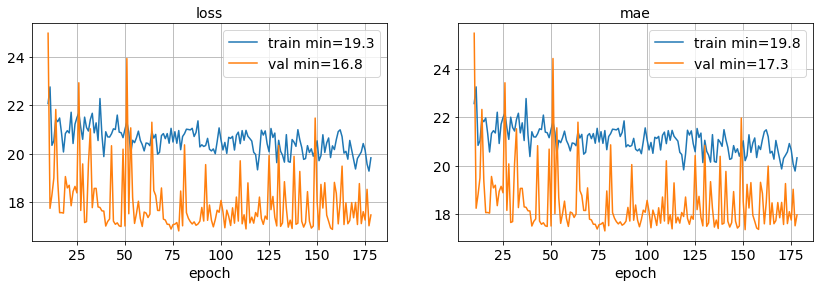

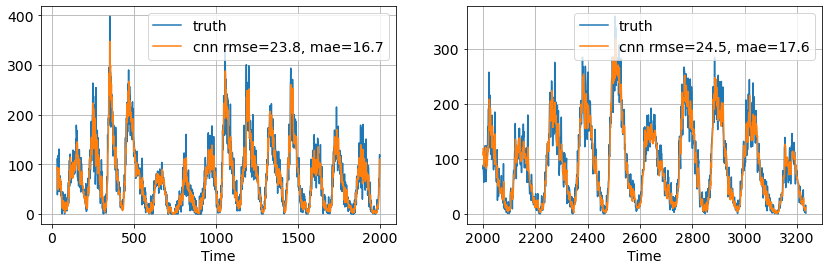

In [108]:
%%time
model = fit_nn(build_cnn(), epochs=500, lr=8e-5, vb=2, patience=100)
model.load_weights(chpt)
plot_pred(model, name='cnn')

Epoch 1/500
31/31 - 1s - loss: 20.6852 - mae: 21.1761 - val_loss: 16.9128 - val_mae: 17.4056 - 758ms/epoch - 24ms/step
Epoch 2/500
31/31 - 0s - loss: 19.9033 - mae: 20.3952 - val_loss: 17.2173 - val_mae: 17.7084 - 322ms/epoch - 10ms/step
Epoch 3/500
31/31 - 0s - loss: 20.6445 - mae: 21.1356 - val_loss: 17.1407 - val_mae: 17.6307 - 320ms/epoch - 10ms/step
Epoch 4/500
31/31 - 0s - loss: 20.9145 - mae: 21.4069 - val_loss: 17.4614 - val_mae: 17.9520 - 317ms/epoch - 10ms/step
Epoch 5/500
31/31 - 0s - loss: 20.1382 - mae: 20.6290 - val_loss: 16.8879 - val_mae: 17.3809 - 360ms/epoch - 12ms/step
Epoch 6/500
31/31 - 0s - loss: 20.2862 - mae: 20.7774 - val_loss: 17.0234 - val_mae: 17.5144 - 318ms/epoch - 10ms/step
Epoch 7/500
31/31 - 0s - loss: 20.2212 - mae: 20.7119 - val_loss: 16.9714 - val_mae: 17.4620 - 312ms/epoch - 10ms/step
Epoch 8/500
31/31 - 0s - loss: 19.9143 - mae: 20.4053 - val_loss: 17.2128 - val_mae: 17.7047 - 316ms/epoch - 10ms/step
Epoch 9/500
31/31 - 0s - loss: 20.3069 - mae: 20

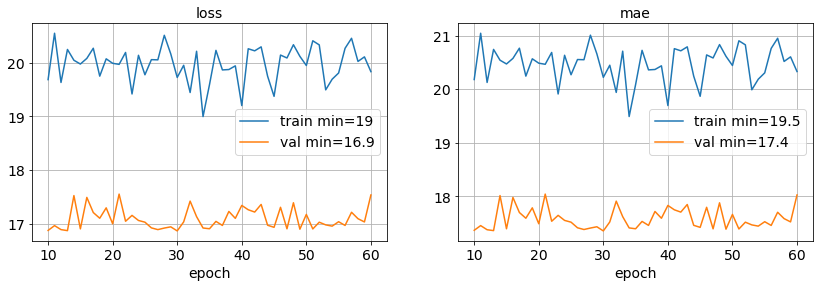

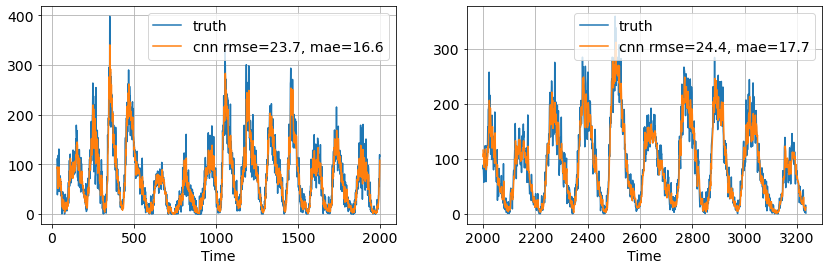

In [110]:
lr = keras.optimizers.schedules.ExponentialDecay(1e-5, 100, 0.95, staircase=True)
fit_nn(model, epochs=500, lr=lr, vb=2)
model.load_weights(chpt)
plot_pred(model, name='cnn')

In [92]:
def build_conv_lstm_fcn(convfil=32, convwid=5, lstm_d=[32, 32], fcn_d=[]):
    ly = keras.layers
    layers = [ly.Conv1D(convfil, convwid, activation='relu', input_shape=[window, 1])]
    layers += [ly.Bidirectional(ly.LSTM(d, return_sequences=True)) for d in lstm_d[:-1]]
    layers += [ly.Bidirectional(ly.LSTM(lstm_d[-1]))]
    layers += [ly.Dense(d, activation='relu') for d in fcn_d]
    layers += [
        ly.Dropout(0.4),
        ly.Dense(1),
        ly.Lambda(lambda x: x * 300.),
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 26, 32)            192       
                                                                 
 bidirectional_28 (Bidirecti  (None, 26, 64)           16640     
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
 lambda_14 (Lambda)          (None, 1)               

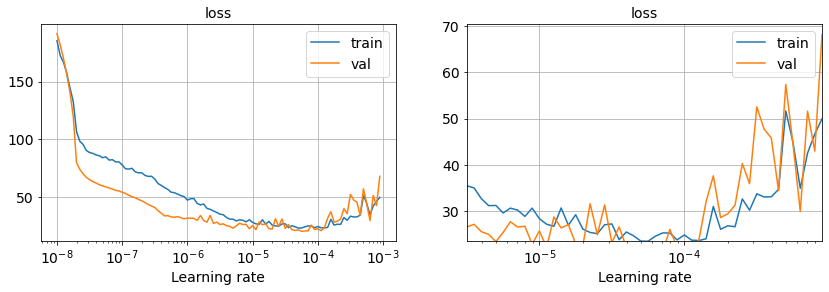

In [85]:
%%time
model = fit_nn(build_conv_lstm_fcn(), epochs=100, lr=-1)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 26, 32)            192       
                                                                 
 bidirectional_30 (Bidirecti  (None, 26, 64)           16640     
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 1)                 65        
                                                                 
 lambda_15 (Lambda)          (None, 1)               

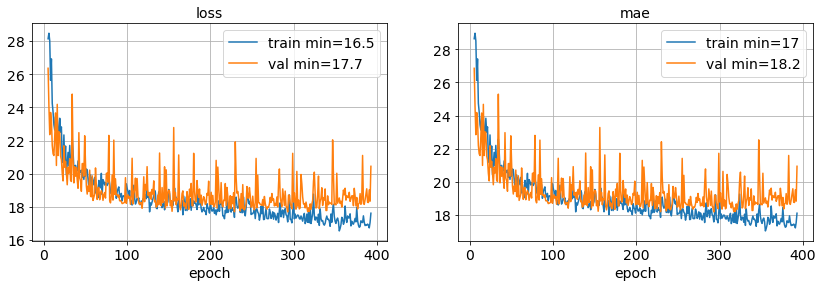

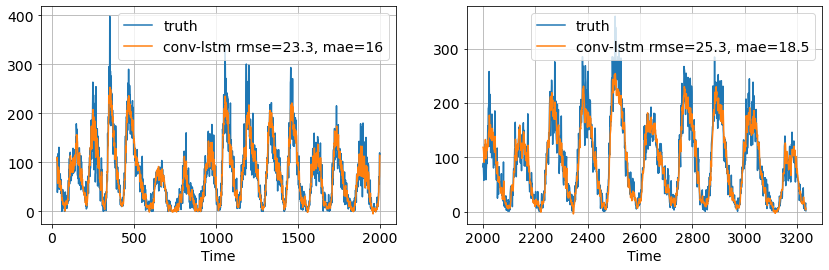

In [86]:
%%time
model = fit_nn(build_conv_lstm_fcn(), epochs=500, lr=1e-5, vb=2, patience=100)
model.load_weights(chpt)
plot_pred(model, name='conv-lstm')

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 26, 32)            192       
                                                                 
 bidirectional_36 (Bidirecti  (None, 26, 64)           16640     
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_61 (Dense)            (None, 30)                1950      
                                                                 
 dense_62 (Dense)            (None, 30)                930       
                                                                 
 dropout_9 (Dropout)         (None, 30)              

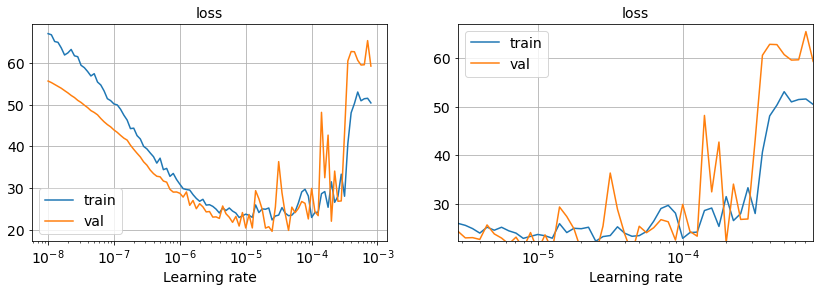

In [93]:
%%time
model = fit_nn(build_conv_lstm_fcn(fcn_d=[30, 30]), epochs=100, lr=-1)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 26, 32)            192       
                                                                 
 bidirectional_40 (Bidirecti  (None, 26, 64)           16640     
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_70 (Dense)            (None, 30)                1950      
                                                                 
 dense_71 (Dense)            (None, 30)                930       
                                                                 
 dropout_12 (Dropout)        (None, 30)              

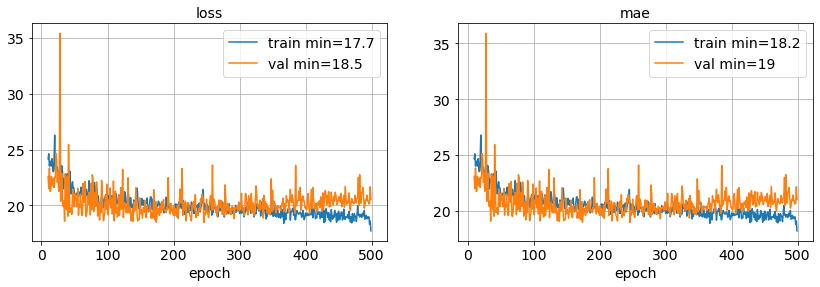

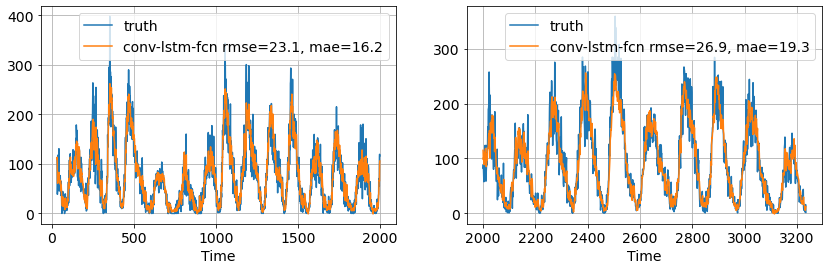

In [97]:
%%time
model = fit_nn(build_conv_lstm_fcn(fcn_d=[30, 30]), epochs=500, lr=1e-5, vb=2, patience=100)
model.load_weights(chpt)
plot_pred(model, name='conv-lstm-fcn')